# Tree-Based Methods & SMOTE & XGBoost

#### (a) Data Download
Download the APS Failure data from: [APS Failure at Scania Trucks](https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks). The dataset includes a training set with 60,000 rows (1,000 positive cases) and 171 columns (1 for the class and 170 numeric attributes).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [2]:
aps_train = pd.read_csv('../data/aps+failure+at+scania+trucks/aps_failure_training_set.csv', skiprows=20)
aps_test = pd.read_csv('../data/aps+failure+at+scania+trucks/aps_failure_test_set.csv', skiprows=20)
aps_train['class'] = aps_train['class'].map({'neg': 0, 'pos': 1})
aps_test['class'] = aps_test['class'].map({'neg': 0, 'pos': 1})
aps_train = aps_train.replace('na', np.nan)
aps_test = aps_test.replace('na', np.nan)
aps_train

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,NaN,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,NaN,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,153002,NaN,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,0,2286,NaN,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,0,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,0,80292,NaN,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


In [3]:
train_missing = aps_train.isnull().sum().sum()
test_missing = aps_test.isnull().sum().sum()
print(f'Train missing values: {train_missing}')
print(f'Test missing values: {test_missing}')

Train missing values: 850015
Test missing values: 228680


#### (b) Data Preparation
This dataset contains missing values. When a large number of values are missing, discarding them isn’t ideal.

1. **Imputation Techniques**: Research methods to handle missing values (data imputation techniques) and apply at least one technique.
2. **Coefficient of Variation**: For each feature, calculate the coefficient of variation $ CV = \frac{s}{m} $, where $ s $ is the standard deviation and $ m $ is the mean.
3. **Correlation Matrix**: Plot a correlation matrix of the features.
4. **High-CV Feature Visualization**: Select the $ \lfloor \sqrt{170} \rfloor $ features with the highest $ CV $ and create scatter and box plots. Can you draw conclusions about the significance of these features from the scatter plots? Note that these are for visualization only.
5. **Class Imbalance**: Determine the number of positive and negative samples. Is this dataset imbalanced?


**This is same as hw5**

GPT Prompt: What kind of data imputation is better for handling high proportion of missing values?

Response:

1. Multivariate Imputation by Chained Equations (MICE)

- Best For: Datasets where the relationships among features are important and where missing data patterns vary across columns.
- How it Works: MICE iteratively fills in missing values by modeling each feature with missing values as a function of other features. This allows each missing value to be informed by values in related columns, preserving relationships in the data.
- Pros: MICE maintains relationships among variables, which helps in complex datasets with high missingness.
- Cons: Computationally intensive and may require tuning.

2. K-Nearest Neighbors (KNN) Imputation

- Best For: Datasets where similar rows are likely to have similar values.
- How it Works: KNN imputation fills in missing values by finding the k nearest rows (based on other feature values) and using the average or majority value of the nearest neighbors for imputation.
- Pros: Preserves data structure by borrowing information from similar rows.
- Cons: Can be slow with large datasets and might not perform well if there is little redundancy in the data.

### K-Nearest Neighbors (KNN) Imputation (K=3)

In [4]:
missing_values = aps_train.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

ab_000    46329
ac_000     3335
ad_000    14861
ae_000     2500
af_000     2500
          ...  
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 169, dtype: int64


**Store the result to csv since this process takes some time**

In [5]:
# imputer = KNNImputer(n_neighbors=3)
# train_data = imputer.fit_transform(aps_train)
# train_data = pd.DataFrame(train_data, columns=aps_train.columns)
# train_data.to_csv('../data/aps+failure+at+scania+trucks/aps_failure_training_set_imputed.csv', index=False)
# train_data

In [6]:
# imputer = KNNImputer(n_neighbors=3)
# test_data = imputer.fit_transform(aps_test)
# test_data = pd.DataFrame(test_data, columns=aps_test.columns)
# test_data.to_csv('../data/aps+failure+at+scania+trucks/aps_failure_test_set_imputed.csv', index=False)
# test_data

**We can read processed data directly since the data has been stored**

In [7]:
train_data = pd.read_csv('../data/aps+failure+at+scania+trucks/aps_failure_training_set_imputed.csv')
test_data = pd.read_csv('../data/aps+failure+at+scania+trucks/aps_failure_test_set_imputed.csv')
train_data

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,76698.0,1.333333,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0,0
1,33058.0,0.000000,0.000000e+00,247.333333,0.0,0.0,0.0,0.0,0.0,0.0,...,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0,0
2,41040.0,0.000000,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0,0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0,0
4,60874.0,0.000000,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,1.333333,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,...,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0,0
59996,2286.0,1.333333,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0,0
59997,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0,0
59998,80292.0,1.333333,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0,0


In [8]:
cv = (train_data.std() / train_data.mean()) * 100
print(cv)

aa_000      245.093758
ab_000      360.580518
ac_000      203.591352
ad_000    24424.322233
ae_000     2332.172810
              ...     
ee_008      324.326396
ee_009      566.486580
ef_000     4738.465473
eg_000     4171.437861
class       768.120976
Length: 171, dtype: float64


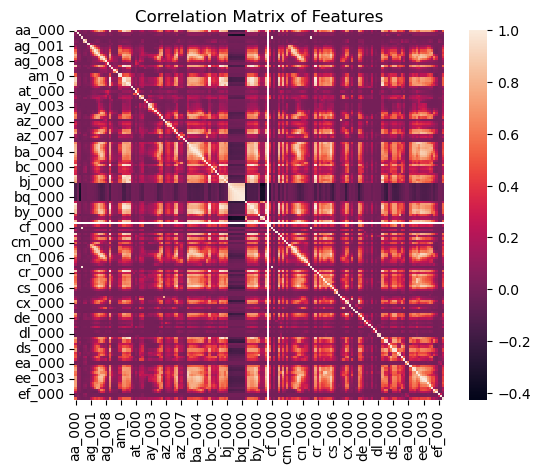

In [9]:
sns.heatmap(train_data.corr(), cbar=True, square=True)
plt.title("Correlation Matrix of Features")
plt.show()

In [10]:
num_features = int(np.sqrt(170))
top_features = cv.sort_values(ascending=False).head(num_features).index
print(top_features)

Index(['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'ag_000', 'dh_000',
       'as_000', 'ay_009', 'az_009', 'ch_000', 'au_000', 'ay_001'],
      dtype='object')


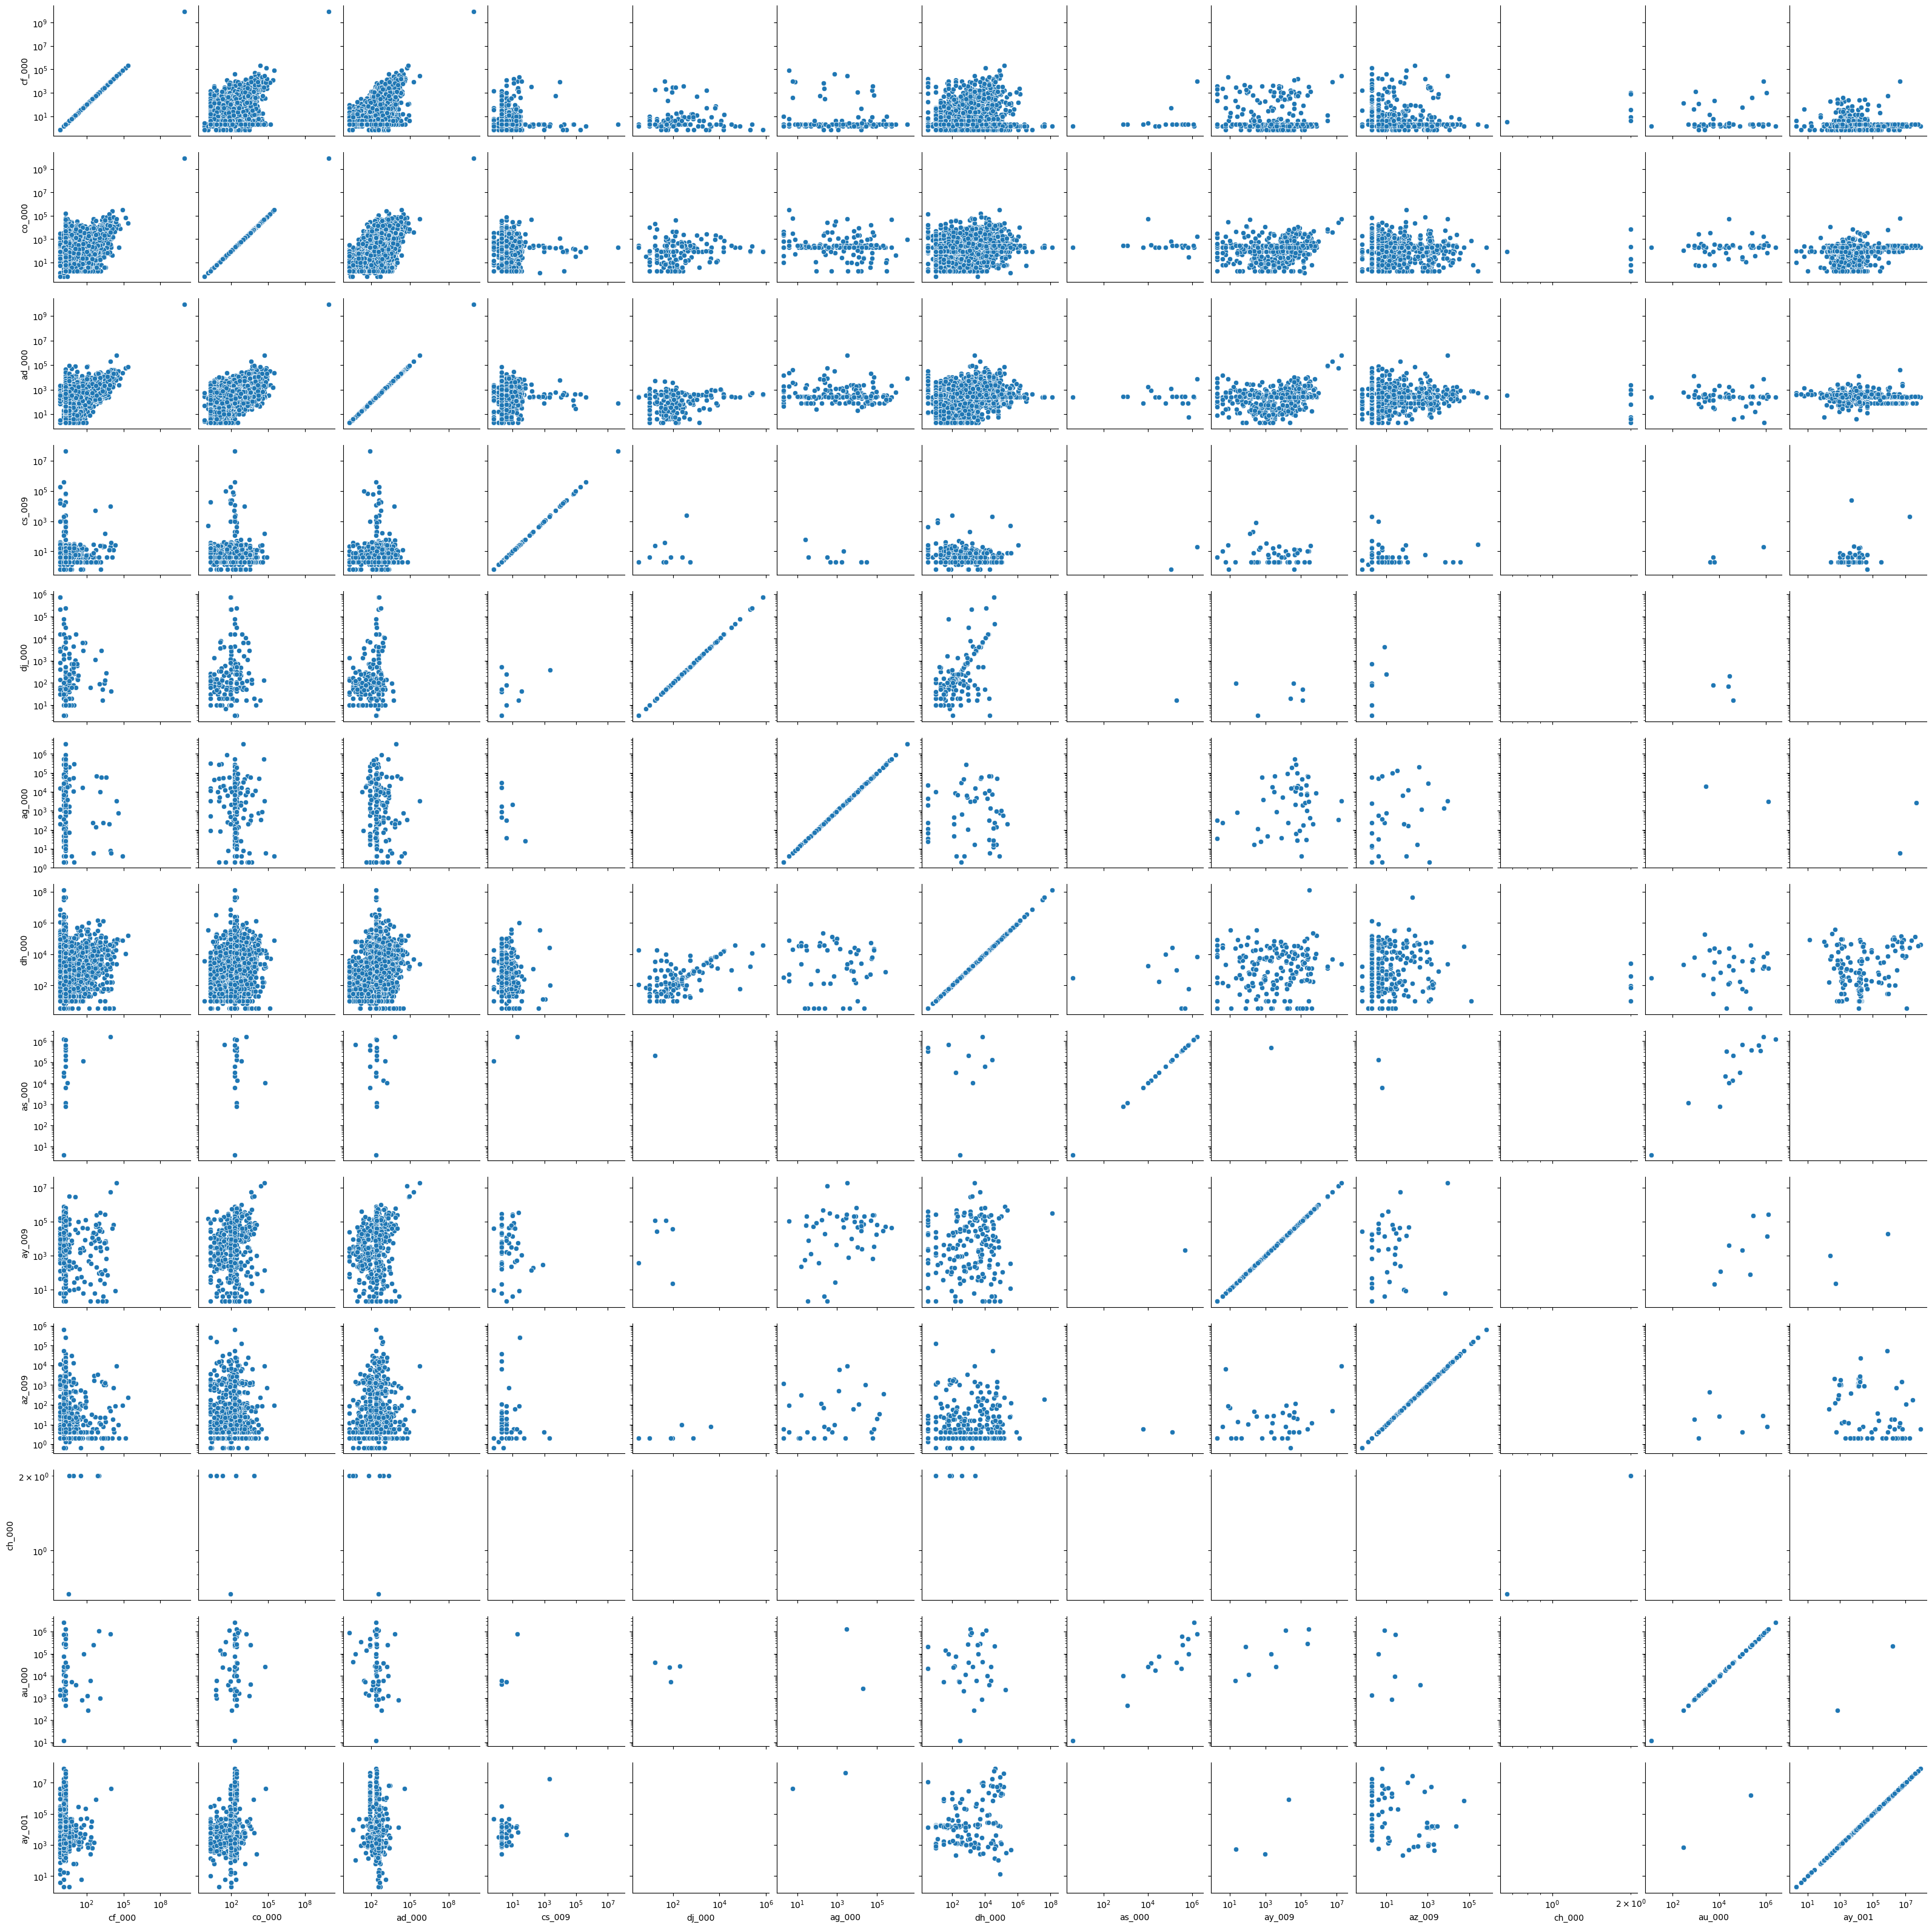

In [11]:
sns.pairplot(train_data[top_features], diag_kind=None).set(xscale="log", yscale="log")
plt.show()

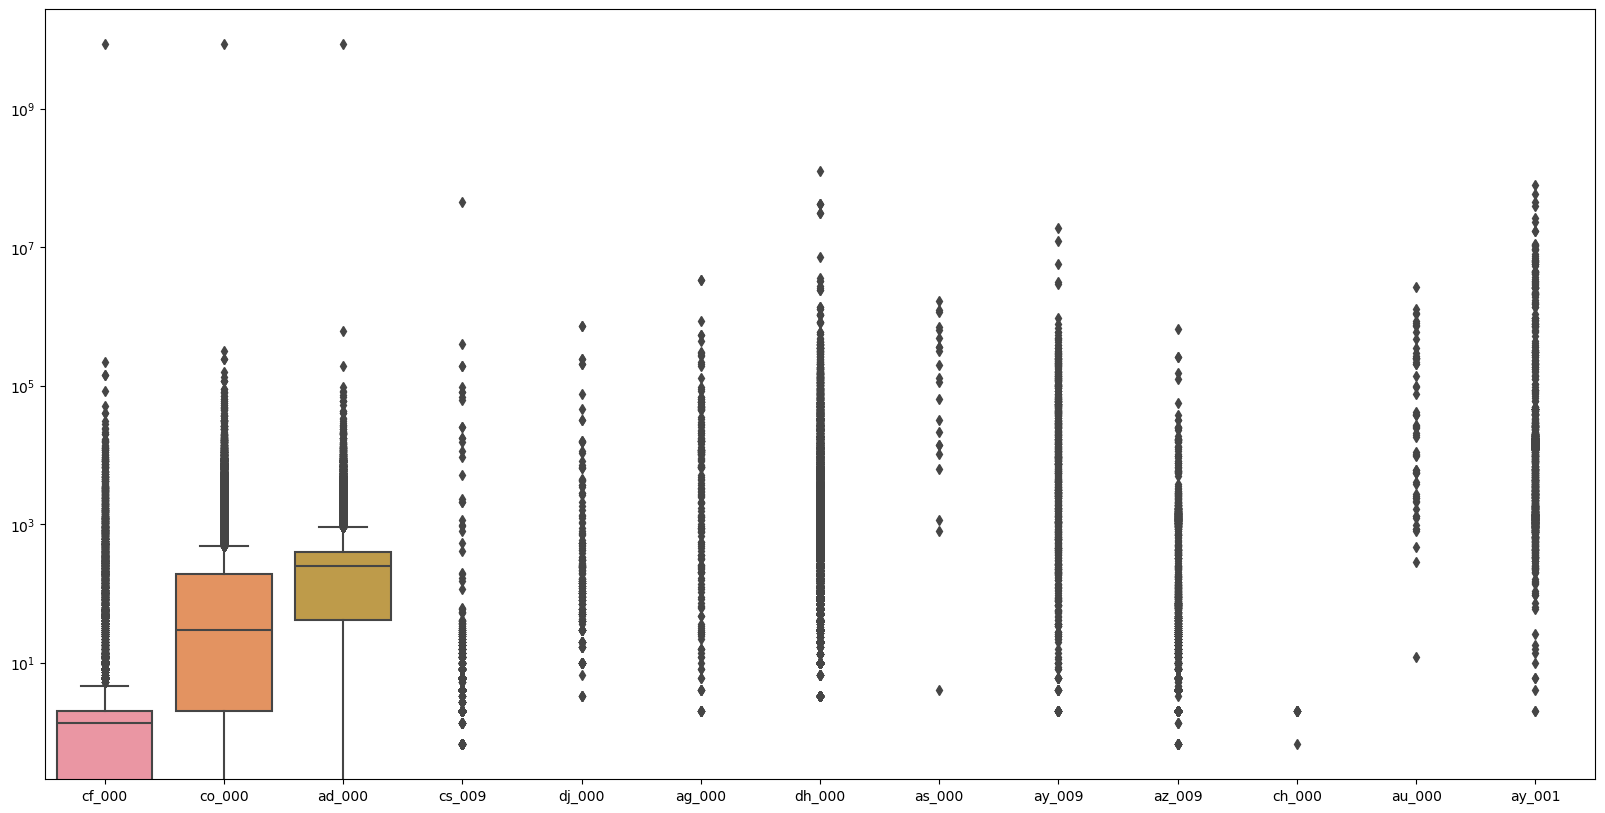

In [12]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=train_data[top_features], orient='v').set_yscale('log')
plt.show()

We can only know what are the relationships between each pair of features but it lacks of some quantitative assessment such as p-values.

<Axes: xlabel='class'>

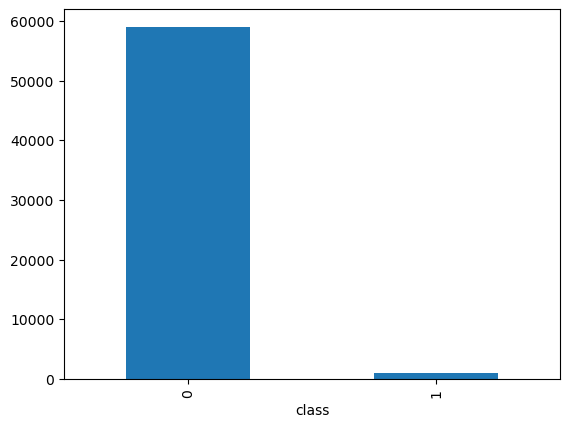

In [13]:
train_data['class'].value_counts().plot(kind='bar')

There is class imbalance in this data set.

### Simple Imputation (Mean)

In [14]:
imputer = SimpleImputer(strategy='mean')
train_data = imputer.fit_transform(aps_train)
train_data = pd.DataFrame(train_data, columns=aps_train.columns)
test_data = imputer.transform(aps_test)
test_data = pd.DataFrame(test_data, columns=aps_test.columns)
train_data

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,153002.0,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,0.0,2286.0,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,0.0,80292.0,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


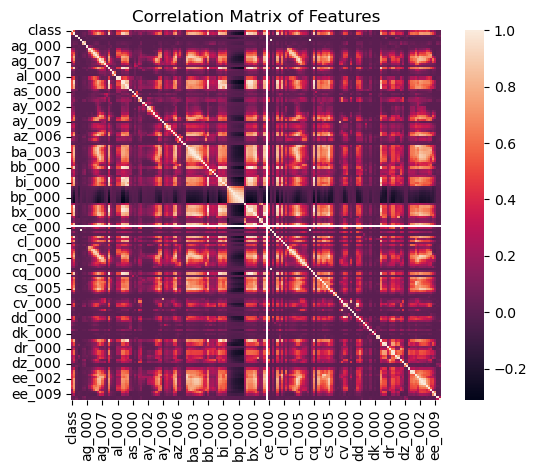

In [15]:
sns.heatmap(train_data.corr(), cbar=True, square=True)
plt.title("Correlation Matrix of Features")
plt.show()

In [16]:
cv = (train_data.std() / train_data.mean()) * 100
cv = cv.drop(columns=['class'])
print(cv)
num_features = int(np.sqrt(170))
top_features = cv.sort_values(ascending=False).head(num_features).index
print(top_features)

class       768.120976
aa_000      245.093758
ab_000      232.839999
ac_000      216.976652
ad_000    18384.762037
              ...     
ee_007      496.248265
ee_008      322.201024
ee_009      562.697857
ef_000     4712.495309
eg_000     4055.324999
Length: 171, dtype: float64
Index(['cs_009', 'cf_000', 'co_000', 'ad_000', 'dh_000', 'dj_000', 'ag_000',
       'as_000', 'ay_009', 'az_009', 'ak_000', 'au_000', 'ch_000'],
      dtype='object')


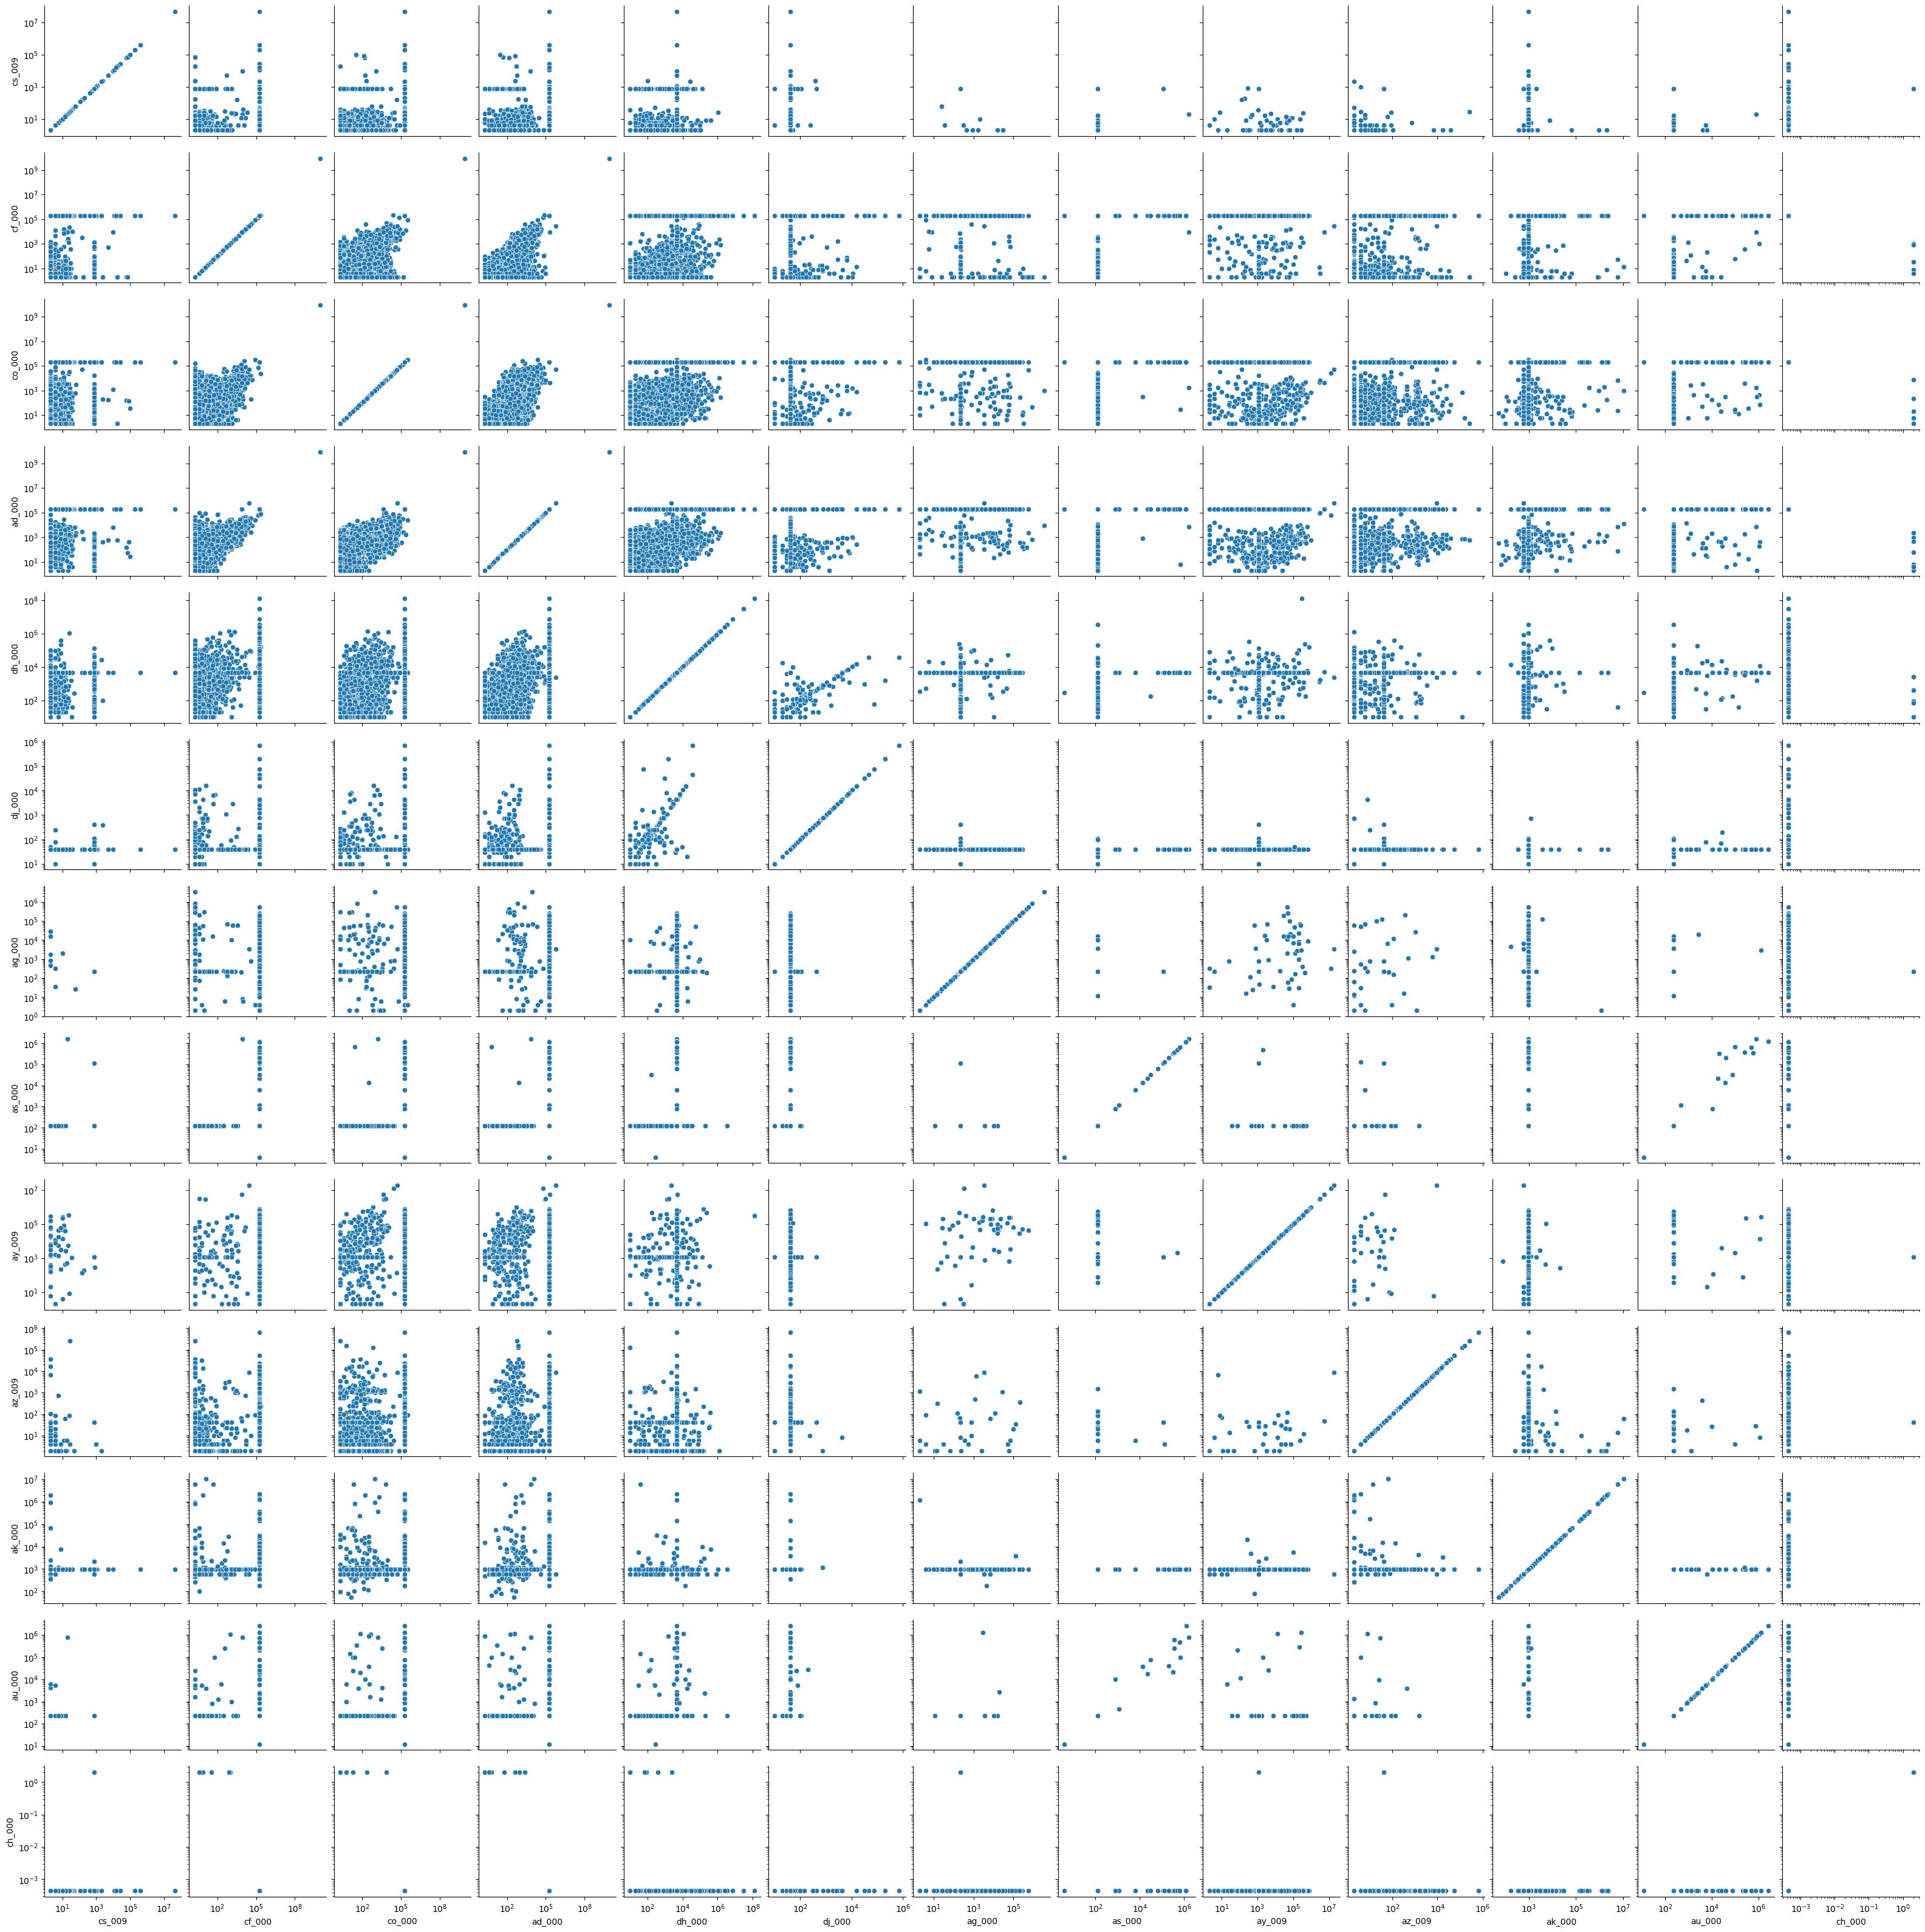

In [17]:
sns.pairplot(train_data[top_features], diag_kind=None).set(xscale='log', yscale='log')
plt.show()

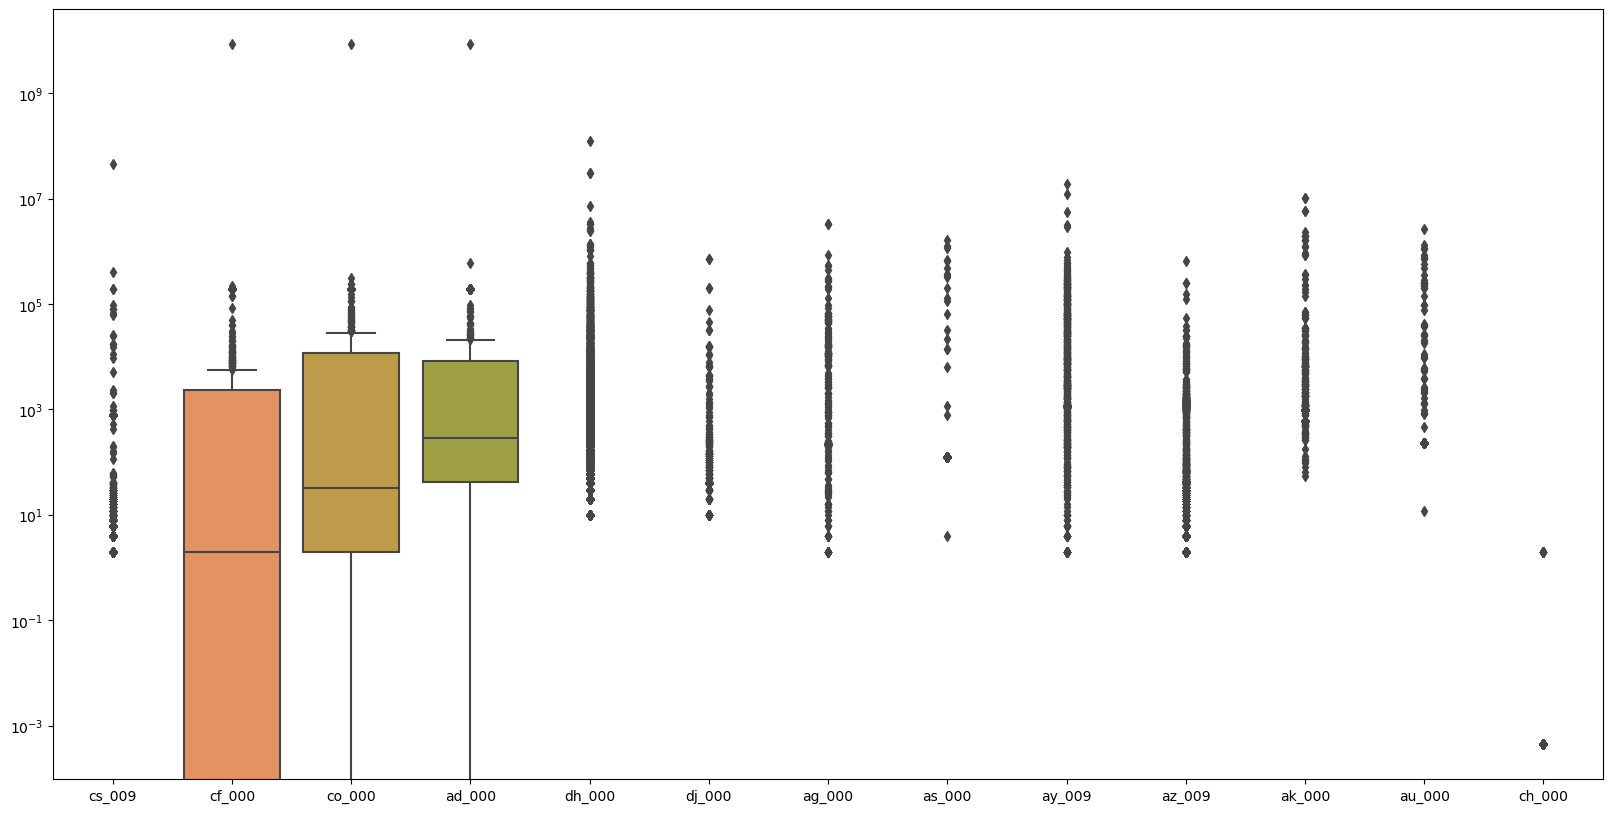

In [18]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=train_data[top_features], orient='v').set(yscale='log')
plt.show()

#### (c) Random Forest Model
Train a random forest classifier without compensating for class imbalance. Calculate and report the confusion matrix, ROC, AUC, and misclassification rates for both training and test sets. Also, calculate the Out-of-Bag (OOB) error estimate and compare it to the test error.


Reference: https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [19]:
train_data = pd.read_csv('../data/aps+failure+at+scania+trucks/aps_failure_training_set_imputed.csv')
test_data = pd.read_csv('../data/aps+failure+at+scania+trucks/aps_failure_test_set_imputed.csv')
X_train = train_data.drop(columns=['class'])
y_train = train_data['class']
X_test = test_data.drop(columns=['class'])
y_test = test_data['class']

In [20]:
random_forest_model = RandomForestClassifier(oob_score=True)
random_forest_model.fit(X_train, y_train)

y_pred_train = random_forest_model.predict(X_train)
y_pred_test = random_forest_model.predict(X_test)

error_train = 1-random_forest_model.score(X_train, y_train)
y_pred_prob_train = random_forest_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_prob_train)
roc_train = roc_auc_score(y_train, y_pred_prob_train)
confusion_train = confusion_matrix(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train)

error_test = 1-random_forest_model.score(X_test, y_test)
y_pred_prob_test = random_forest_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
roc_test = roc_auc_score(y_test, y_pred_prob_test)
confusion_test = confusion_matrix(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print('Random Forest Model')
print('-'*20)
print('Train Data')
print('Misclassification Rate:', error_train)
print('ROC AUC:', roc_train)
print('Confusion Matrix: \n', confusion_train)
print('Classification Report: \n', report_train)
print('-'*20)
print('Test Data')
print('Misclassification Rate:', error_test)
print('ROC AUC:', roc_test)
print('Confusion Matrix: \n', confusion_test)
print('Classification Report: \n', report_test)
print('-'*20)
print('Out of Bag Error:', 1-random_forest_model.oob_score_)
print('-'*20)

Random Forest Model
--------------------
Train Data
Misclassification Rate: 1.666666666666483e-05
ROC AUC: 1.0
Confusion Matrix: 
 [[59000     0]
 [    1   999]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

--------------------
Test Data
Misclassification Rate: 0.008187500000000014
ROC AUC: 0.9939723946666668
Confusion Matrix: 
 [[15608    17]
 [  114   261]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     15625
         1.0       0.94      0.70      0.80       375

    accuracy                           0.99     16000
   macro avg       0.97      0.85      0.90     16000
weighted avg       0.99      0.99 

The out-of-bag error is lower than the error(misclassification rate) in testing data.

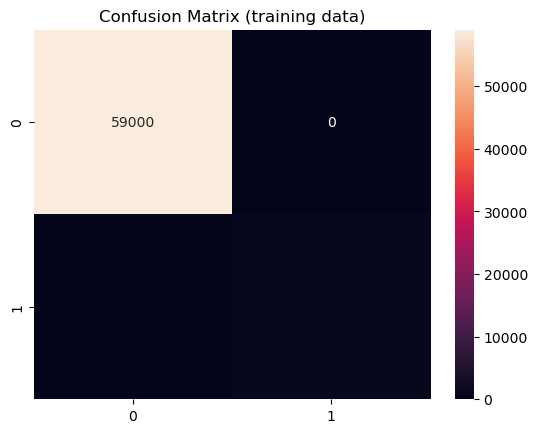

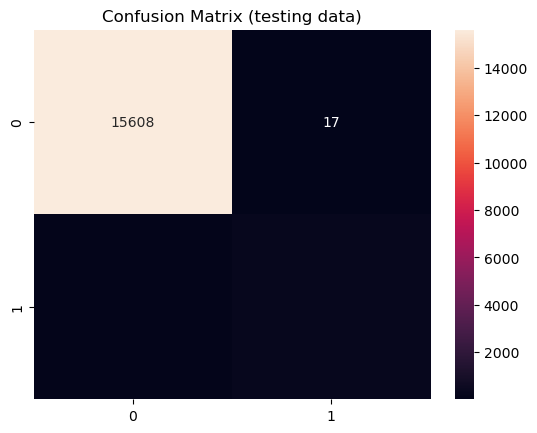

In [21]:
sns.heatmap(confusion_train, annot=True, fmt='d')
plt.title('Confusion Matrix (training data)')
plt.show()

sns.heatmap(confusion_test, annot=True, fmt='d')
plt.title('Confusion Matrix (testing data)')
plt.show()

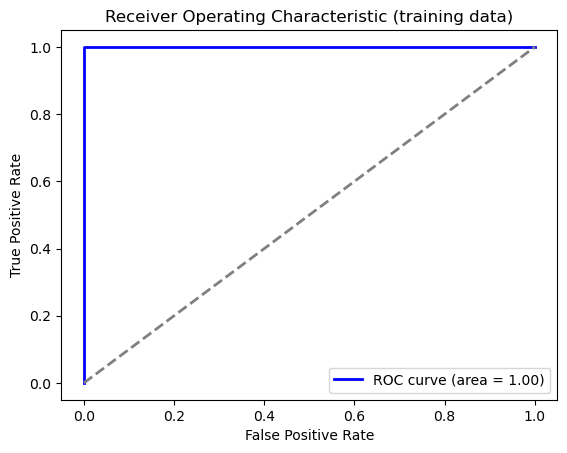

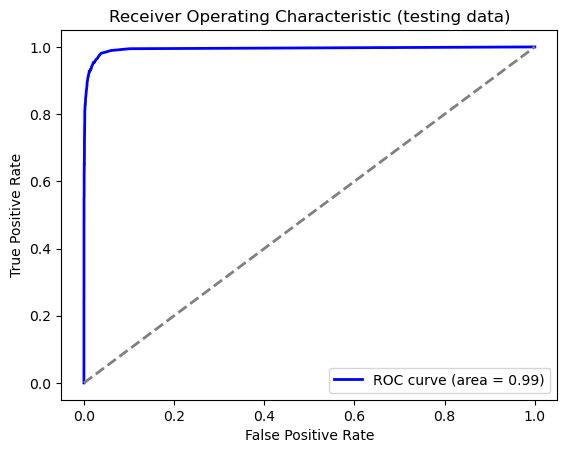

In [22]:
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC curve (area = {roc_train:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (training data)')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC curve (area = {roc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (testing data)')
plt.legend(loc="lower right")
plt.show()

#### (d) Addressing Class Imbalance in Random Forests
Research methods to handle class imbalance in random forests. Apply a method to compensate for class imbalance and repeat (c). Compare these results with those obtained in (c).


GPT Prompt: Recommend some algorithm to deal with class imbalance problem

Response:

SMOTE (Synthetic Minority Over-sampling Technique):
- SMOTE generates synthetic samples for the minority class by interpolating between minority samples and their nearest neighbors.
- Pros: Increases diversity in the minority class, reduces overfitting compared to simple duplication.
- Cons: Can introduce noise if synthetic samples are generated near outliers.

Random Over-sampling:
- Duplicates existing minority class samples until both classes are balanced.
- Pros: Easy to implement.
- Cons: Increases risk of overfitting since minority samples are duplicated.

Random Under-sampling:
- Reduces the majority class by randomly removing samples, balancing it with the minority class.
- Pros: Reduces computation time by reducing the dataset size.
- Cons: May lose valuable information from the majority class.

In [23]:
sampling = RandomOverSampler()
X_train_resampled, y_train_resampled = sampling.fit_resample(X_train, y_train)
X_train_resampled

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,1.333333,2.130706e+09,280.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.000000,0.000000e+00,247.333333,0.000000,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.000000,2.280000e+02,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.000000,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.000000,1.368000e+03,458.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117995,1317250.0,2.000000,7.102388e+08,264.000000,0.000000,0.0,0.0,0.0,37486.0,3904962.0,...,4291100.0,1750984.0,3671308.0,5377012.0,8632340.0,23266310.0,266496.0,56.0,0.0,0.0
117996,286216.0,0.666667,8.640000e+02,600.000000,940.000000,1424.0,0.0,13692.0,429882.0,3309500.0,...,1161150.0,573596.0,1493162.0,3061390.0,5192124.0,979418.0,68516.0,184.0,0.0,4.0
117997,269606.0,5.333333,7.102360e+08,264.000000,152.666667,526.0,0.0,0.0,28.0,471958.0,...,1738684.0,1097858.0,2591636.0,1334056.0,2424170.0,3030864.0,26188.0,0.0,0.0,0.0
117998,341996.0,4.000000,1.675333e+03,247.333333,0.000000,0.0,0.0,0.0,0.0,24598.0,...,4468102.0,1422974.0,3581324.0,2990914.0,1580312.0,444932.0,74578.0,1048.0,0.0,0.0


In [24]:
random_forest_model = RandomForestClassifier(oob_score=True)
random_forest_model.fit(X_train_resampled, y_train_resampled)

y_pred_train = random_forest_model.predict(X_train_resampled)
y_pred_test = random_forest_model.predict(X_test)

error_train = 1-random_forest_model.score(X_train_resampled, y_train_resampled)
y_pred_prob_train = random_forest_model.predict_proba(X_train_resampled)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, y_pred_prob_train)
roc_train = roc_auc_score(y_train_resampled, y_pred_prob_train)
confusion_train = confusion_matrix(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)

error_test = 1-random_forest_model.score(X_test, y_test)
y_pred_prob_test = random_forest_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
roc_test = roc_auc_score(y_test, y_pred_prob_test)
confusion_test = confusion_matrix(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print('Random Forest Model')
print('-'*20)
print('Train Data')
print('Misclassification Rate:', error_train)
print('ROC AUC:', roc_train)
print('Confusion Matrix: \n', confusion_train)
print('Classification Report: \n', report_train)
print('-'*20)
print('Test Data')
print('Misclassification Rate:', error_test)
print('ROC AUC:', roc_test)
print('Confusion Matrix: \n', confusion_test)
print('Classification Report: \n', report_test)
print('-'*20)
print('Out of Bag Error:', 1-random_forest_model.oob_score_)
print('-'*20)

Random Forest Model
--------------------
Train Data
Misclassification Rate: 0.0
ROC AUC: 1.0
Confusion Matrix: 
 [[59000     0]
 [    0 59000]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       1.00      1.00      1.00     59000

    accuracy                           1.00    118000
   macro avg       1.00      1.00      1.00    118000
weighted avg       1.00      1.00      1.00    118000

--------------------
Test Data
Misclassification Rate: 0.010437499999999988
ROC AUC: 0.991297792
Confusion Matrix: 
 [[15603    22]
 [  145   230]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.91      0.61      0.73       375

    accuracy                           0.99     16000
   macro avg       0.95      0.81      0.86     16000
weighted avg       0.99      0.99      0.99     16000

----

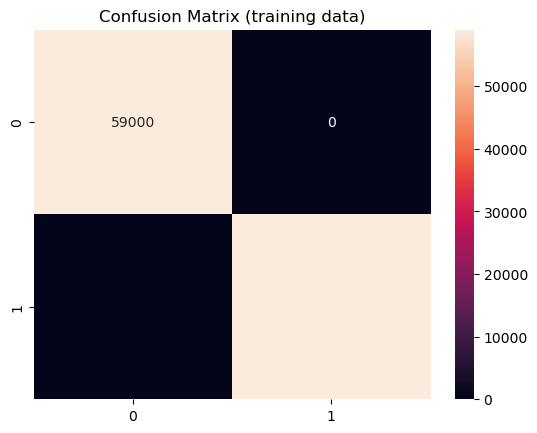

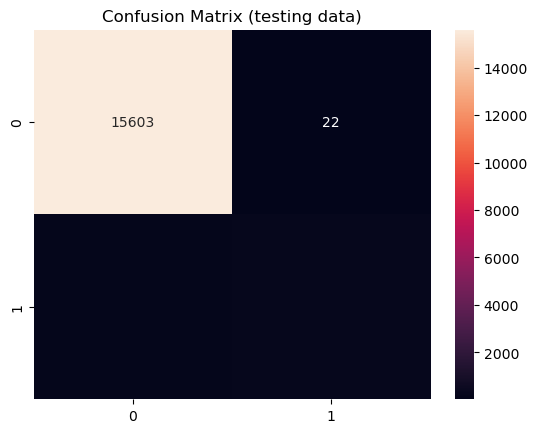

In [25]:
sns.heatmap(confusion_train, annot=True, fmt='d')
plt.title('Confusion Matrix (training data)')
plt.show()

sns.heatmap(confusion_test, annot=True, fmt='d')
plt.title('Confusion Matrix (testing data)')
plt.show()

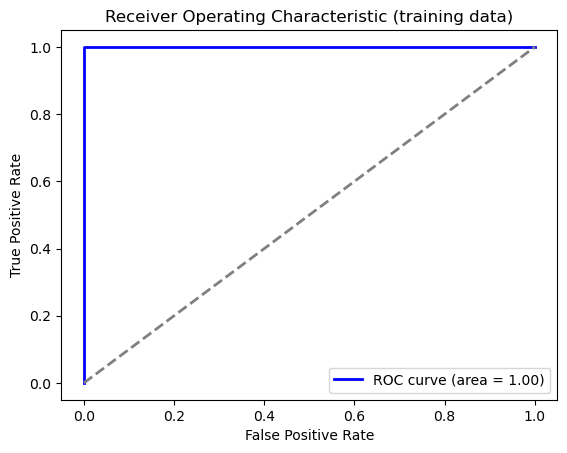

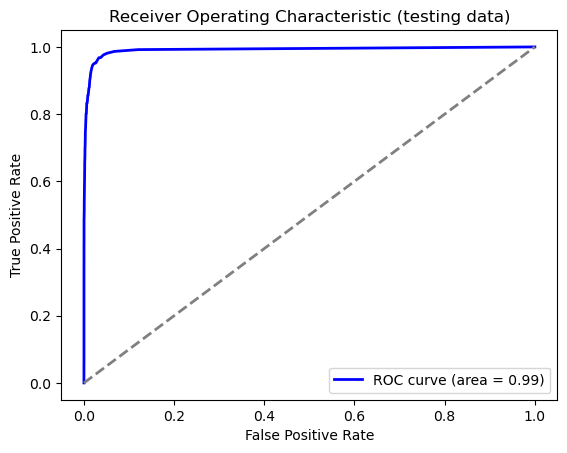

In [26]:
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC curve (area = {roc_train:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (training data)')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC curve (area = {roc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (testing data)')
plt.legend(loc="lower right")
plt.show()

In this case, the out-of-bag score of oversampling data is very close to 1, which means the model performs better than the model using original data. However, the testing error (misclassification rate for testing data) decrease a little bit. Maybe it proves that the model will be prone to overfitting if we use random oversampling because the minority samples are duplicated.

#### (e) XGBoost and Model Trees
In univariate trees, only one feature is used at each split, while model trees (or multivariate trees) allow all features to be used at a node. A model tree uses a linear model as the split rule at each node, as opposed to a univariate decision (e.g., $ X_j > s $).

For this exercise:
- Use L1-penalized logistic regression at each node in XGBoost.
- Perform cross-validation to determine $ \alpha $ (the regularization term).
- Train the model on the APS dataset without compensating for class imbalance. Use 5-fold, 10-fold, or leave-one-out cross-validation to estimate error and compare with test error.
- Report the confusion matrix, ROC, and AUC for training and test sets.


In [27]:
params = {
    'alpha': np.linspace(0, 20, 100),
}

xgb_model = XGBClassifier()
grid_search = GridSearchCV(xgb_model, params, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print('Best Parameters:', best_params)
print('Best Score:', best_score)

Best Parameters: {'alpha': 0.20202020202020202}
Best Score: 0.9944666666666666


In [28]:
best_xbg_model = XGBClassifier(alpha=best_params['alpha'])
best_xbg_model.fit(X_train, y_train)

y_pred_train = best_xbg_model.predict(X_train)
y_pred_test = best_xbg_model.predict(X_test)

error_train = 1-best_xbg_model.score(X_train, y_train)
y_pred_prob_train = best_xbg_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_prob_train)
roc_train = roc_auc_score(y_train, y_pred_prob_train)
confusion_train = confusion_matrix(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train)

error_test = 1-best_xbg_model.score(X_test, y_test)
y_pred_prob_test = best_xbg_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
roc_test = roc_auc_score(y_test, y_pred_prob_test)
confusion_test = confusion_matrix(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print('XGBoost Tree Model (Logistic Regression (L1 penalty))')
print('-'*20)
print('Train Data')
print('Misclassification Rate:', error_train)
print('ROC AUC:', roc_train)
print('Confusion Matrix: \n', confusion_train)
print('Classification Report: \n', report_train)
print('-'*20)
print('Test Data')
print('Misclassification Rate:', error_test)
print('ROC AUC:', roc_test)
print('Confusion Matrix: \n', confusion_test)
print('Classification Report: \n', report_test)
print('-'*20)
print('Out of Bag Error:', 1-random_forest_model.oob_score_)
print('-'*20)

XGBoost Tree Model (Logistic Regression (L1 penalty))
--------------------
Train Data
Misclassification Rate: 0.0
ROC AUC: 1.0
Confusion Matrix: 
 [[59000     0]
 [    0  1000]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

--------------------
Test Data
Misclassification Rate: 0.006812499999999999
ROC AUC: 0.9952568319999999
Confusion Matrix: 
 [[15603    22]
 [   87   288]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     15625
         1.0       0.93      0.77      0.84       375

    accuracy                           0.99     16000
   macro avg       0.96      0.88      0.92     16000
weighted avg      

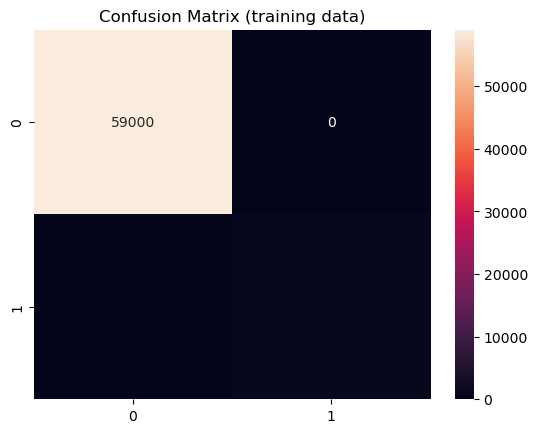

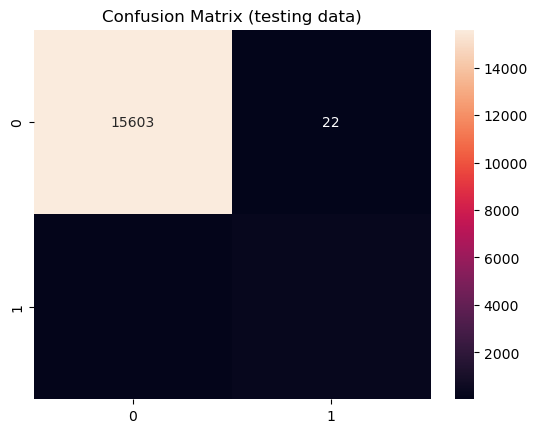

In [29]:
sns.heatmap(confusion_train, annot=True, fmt='d')
plt.title('Confusion Matrix (training data)')
plt.show()

sns.heatmap(confusion_test, annot=True, fmt='d')
plt.title('Confusion Matrix (testing data)')
plt.show()

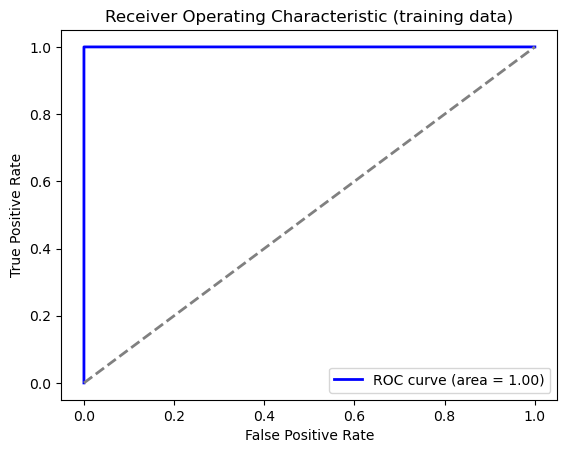

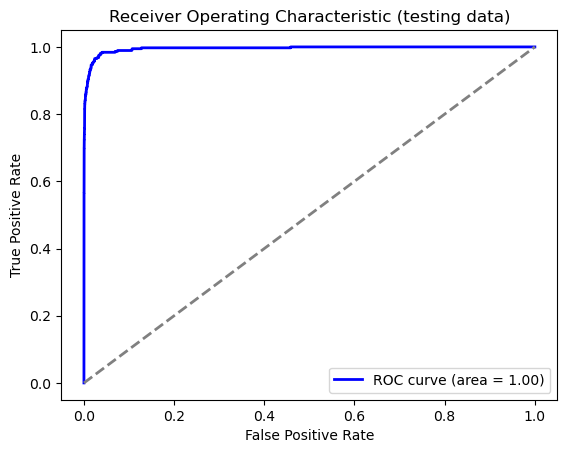

In [30]:
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC curve (area = {roc_train:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (training data)')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC curve (area = {roc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (testing data)')
plt.legend(loc="lower right")
plt.show()

### (f) SMOTE Preprocessing with XGBoost
Use SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance, then train an XGBoost model with L1-penalized logistic regression at each node. Repeat the steps from (e). Ensure correct cross-validation methodology, and compare results between the SMOTE and non-SMOTE cases.

In [31]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.000000,1.333333,2.130706e+09,280.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,...,1.240520e+06,4.933840e+05,7.210440e+05,4.697920e+05,3.391560e+05,1.579560e+05,7.322400e+04,0.000000,0.0,0.0
1,33058.000000,0.000000,0.000000e+00,247.333333,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,...,4.214000e+05,1.780640e+05,2.933060e+05,2.454160e+05,1.336540e+05,8.114000e+04,9.757600e+04,1500.000000,0.0,0.0
2,41040.000000,0.000000,2.280000e+02,100.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,...,2.773780e+05,1.598120e+05,4.239920e+05,4.095640e+05,3.207460e+05,1.580220e+05,9.512800e+04,514.000000,0.0,0.0
3,12.000000,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.000000,0.000000,3.180000e+02,...,2.400000e+02,4.600000e+01,5.800000e+01,4.400000e+01,1.000000e+01,0.000000e+00,0.000000e+00,0.000000,4.0,32.0
4,60874.000000,0.000000,1.368000e+03,458.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,...,6.220120e+05,2.297900e+05,4.052980e+05,3.471880e+05,2.869540e+05,3.115600e+05,4.339540e+05,1218.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117995,557205.373589,0.505342,8.093024e+02,197.978307,0.0,0.0,0.0,9165.379969,243982.512722,2.506587e+06,...,1.187426e+06,6.330394e+05,1.614643e+06,2.796661e+06,1.513678e+06,2.373936e+06,2.455792e+04,14.149564,0.0,0.0
117996,660081.891093,0.109851,0.000000e+00,247.333333,0.0,0.0,0.0,0.000000,0.000000,2.512053e+04,...,7.034441e+06,3.281859e+06,6.562652e+06,5.151401e+06,3.660920e+06,1.876416e+06,1.915267e+06,51904.260828,0.0,0.0
117997,295776.857383,2.353347,2.130706e+09,2491.700497,0.0,0.0,0.0,10533.169523,222760.521635,1.773255e+06,...,1.133748e+06,5.133996e+05,1.070269e+06,1.663441e+06,5.485702e+05,1.302190e+05,9.270052e+03,0.000000,0.0,0.0
117998,313298.532211,2.240634,0.000000e+00,247.333333,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,...,2.162671e+06,1.155143e+06,2.453995e+06,2.400771e+06,2.258807e+06,1.485263e+06,1.700408e+06,41181.936961,0.0,0.0


In [32]:
params = {
    'alpha': np.linspace(0, 20, 100),
}

xgb_model = XGBClassifier()
grid_search = GridSearchCV(xgb_model, params, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print('Best Parameters:', best_params)
print('Best Score:', best_score)

Best Parameters: {'alpha': 0.0}
Best Score: 0.9972033898305085


In [33]:
best_xbg_model = XGBClassifier(alpha=best_params['alpha'])
best_xbg_model.fit(X_train_resampled, y_train_resampled)

y_pred_train = best_xbg_model.predict(X_train_resampled)
y_pred_test = best_xbg_model.predict(X_test)

error_train = 1-best_xbg_model.score(X_train_resampled, y_train_resampled)
y_pred_prob_train = best_xbg_model.predict_proba(X_train_resampled)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, y_pred_prob_train)
roc_train = roc_auc_score(y_train_resampled, y_pred_prob_train)
confusion_train = confusion_matrix(y_train_resampled, y_pred_train)
report_train = classification_report(y_train_resampled, y_pred_train)

error_test = 1-best_xbg_model.score(X_test, y_test)
y_pred_prob_test = best_xbg_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
roc_test = roc_auc_score(y_test, y_pred_prob_test)
confusion_test = confusion_matrix(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print('XGBoost Tree Model (Logistic Regression (L1 penalty) & SMOTE)')
print('-'*20)
print('Train Data')
print('Misclassification Rate:', error_train)
print('ROC AUC:', roc_train)
print('Confusion Matrix: \n', confusion_train)
print('Classification Report: \n', report_train)
print('-'*20)
print('Test Data')
print('Misclassification Rate:', error_test)
print('ROC AUC:', roc_test)
print('Confusion Matrix: \n', confusion_test)
print('Classification Report: \n', report_test)
print('-'*20)
print('Out of Bag Error:', 1-random_forest_model.oob_score_)
print('-'*20)

XGBoost Tree Model (Logistic Regression (L1 penalty) & SMOTE)
--------------------
Train Data
Misclassification Rate: 0.0
ROC AUC: 1.0
Confusion Matrix: 
 [[59000     0]
 [    0 59000]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       1.00      1.00      1.00     59000

    accuracy                           1.00    118000
   macro avg       1.00      1.00      1.00    118000
weighted avg       1.00      1.00      1.00    118000

--------------------
Test Data
Misclassification Rate: 0.008937500000000043
ROC AUC: 0.9920616959999999
Confusion Matrix: 
 [[15547    78]
 [   65   310]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15625
         1.0       0.80      0.83      0.81       375

    accuracy                           0.99     16000
   macro avg       0.90      0.91      0.90     16000
weighted a

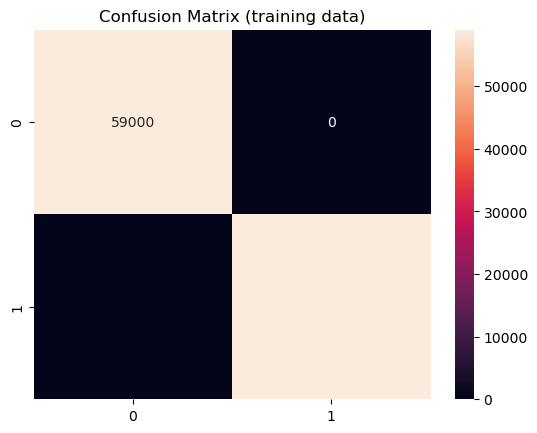

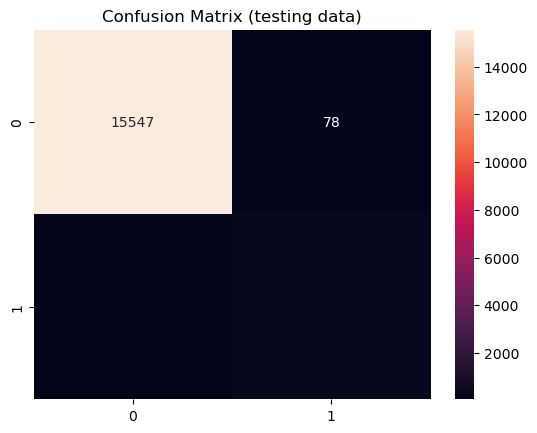

In [34]:
sns.heatmap(confusion_train, annot=True, fmt='d')
plt.title('Confusion Matrix (training data)')
plt.show()

sns.heatmap(confusion_test, annot=True, fmt='d')
plt.title('Confusion Matrix (testing data)')
plt.show()

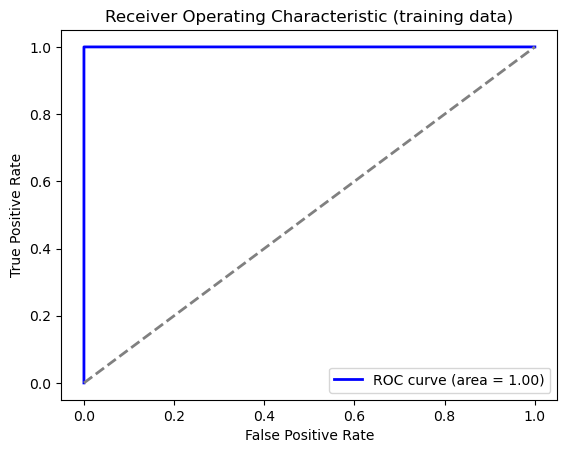

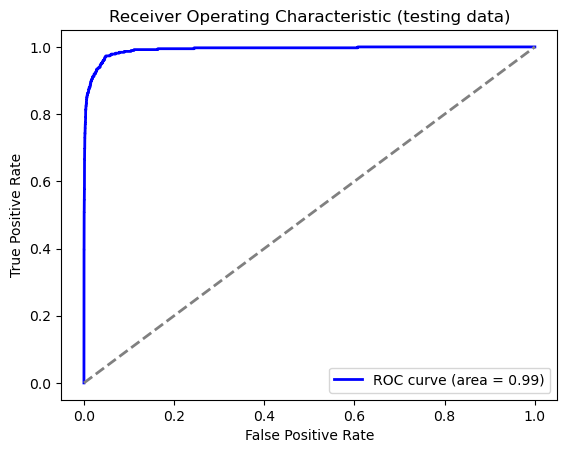

In [35]:
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC curve (area = {roc_train:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (training data)')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC curve (area = {roc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (testing data)')
plt.legend(loc="lower right")
plt.show()

## ISLR Exercises


### ISLR 6.6.3

Suppose we estimate the regression coefficients in a linear regression model by minimizing

$
\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 \quad \text{subject to} \quad \sum_{j=1}^{p} |\beta_j| \leq s
$

for a particular value of $ s $. For parts (a) through (e), indicate which of i through v is correct. Justify your answer.



#### (a) As we increase $ s $ from 0, the training RSS will:
   i. Increase initially, and then eventually start decreasing in an inverted U shape.  
   ii. Decrease initially, and then eventually start increasing in a U shape.  
   iii. Steadily increase.  
   iv. Steadily decrease.  
   v. Remain constant.


The training RSS will steadily decrease. When s is 0, the model only uses $ B_0 $ and training RSS will be high. As s increases, there will be less constraint on coefficient $ B_j $, so the model has more flexibility to fit the data.


#### (b) Repeat (a) for test RSS.


The test RSS will decrease initially and then start increasing in a U shape. The reason for the decreasing state is same as (a), but after a threshold, the test RSS will increase because the model will begin overfittng.


#### (c) Repeat (a) for variance.


The variance will steadily increase. When s=0, the model is less sensitive to data. As s increases, the model will be more flexible to fit training data, and the variance will increase.


#### (d) Repeat (a) for (squared) bias.


The bias will steadily decrease. Oppisite to the variance, if the model be more flexible, the bias will decrease.


#### (e) Repeat (a) for the irreducible error.

The irreducible error remain constant as it does not depend on the model.

### ISLR 6.6.5

It is well-known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore this property in a very simple setting.

Suppose that $ n = 2 $, $ p = 2 $, $ x_{11} = x_{12} $, $ x_{21} = x_{22} $. Furthermore, suppose that $ y_1 + y_2 = 0 $ and $ x_{11} + x_{21} = 0 $ and $ x_{12} + x_{22} = 0 $, so that the estimate for the intercept in a least squares, ridge regression, or lasso model is zero: $ \hat{\beta}_0 = 0 $.



#### (a) Write out the ridge regression optimization problem in this setting.


$$
(y_1-\hat{\beta}_1x_1-\hat{\beta}_2x_1)^2 + (y_2-\hat{\beta}_1x_2-\hat{\beta}_2x_2)^2 + \lambda{(\hat{\beta}_1^2+\hat{\beta}_2^2)} 
$$ 


#### (b) Argue that in this setting, the ridge coefficient estimates satisfy $ \hat{\beta}_1 = \hat{\beta}_2 $.


Since $ x_{11} = x_{12} $  and $ x_{21} = x_{22} $, they are correlated variables. Ridge regression will shrink the coefficients of correlated variables because the penalized function will be minimize if $ \beta_1 $ and $ \beta_2 $ are same value.


#### (c) Write out the lasso optimization problem in this setting.


$$
(y_1-\hat{\beta}_1x_1-\hat{\beta}_2x_1)^2 + (y_2-\hat{\beta}_1x_2-\hat{\beta}_2x_2)^2 + \lambda{(|\hat{\beta}_1|+|\hat{\beta}_2|)} 
$$ 


#### (d) Argue that in this setting, the lasso coefficients $ \hat{\beta}_1 $ and $ \hat{\beta}_2 $ are not unique—in other words, there are many possible solutions to the optimization problem in (c). Describe these solutions.


In Lasso regression, when predictors are correlated, the model will ignore one of the predictors (Shrink to 0) and the other predictor can be any value. As a result, the model can has many solutions.

### ISLR 8.4.5

Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of $ X $, produce 10 estimates of $ P(\text{Class is Red} \mid X) $:

$
0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, \text{ and } 0.75.
$

There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

- Majority Vote: In the case above, if the probability is higher than 0.5, then the model will predict the class is red. There are 6 out of 10 results higher than 0.5, which means the final result will be the class red because it has higher frequency of occurrence than class green.

- Average Probability: The average probability above is 0.45, which is lower than 0.5. As a result, the model will predict the class green.

### ISLR 9.7.3


Here we explore the maximal margin classifier on a toy data set.



#### (a) 
We are given $ n = 7 $ observations in $ p = 2 $ dimensions. For each observation, there is an associated class label.

| Obs. |  $ X_1 $  |  $ X_2 $  |  $ Y $  |
|------|-----------|-----------|---------|
| 1    | 3         | 4         | Red     |
| 2    | 2         | 2         | Red     |
| 3    | 4         | 4         | Red     |
| 4    | 1         | 4         | Red     |
| 5    | 2         | 1         | Blue    |
| 6    | 4         | 3         | Blue    |
| 7    | 4         | 1         | Blue    |

Sketch the observations.


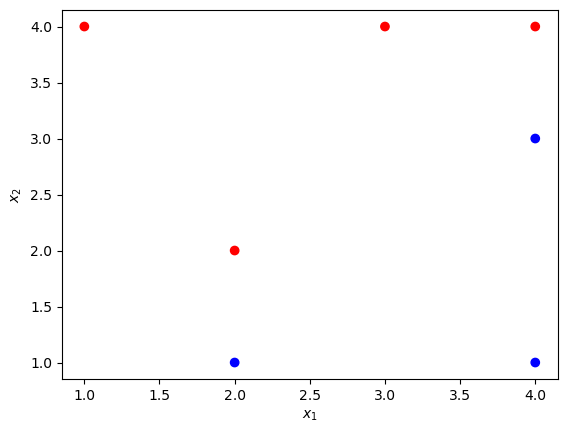

In [36]:
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
colors = ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']

plt.scatter(x1, x2, c=colors)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()


#### (b) 
Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)).


We can observe two points with same x1 value but different color, such as 
red point (2, 2) blue pont (2, 1) and red point(4, 4) blue point (4, 3).
Their x2 value difference is 1, so we can seperate them by the equation $ x_2 = x_1 - 0.5 $

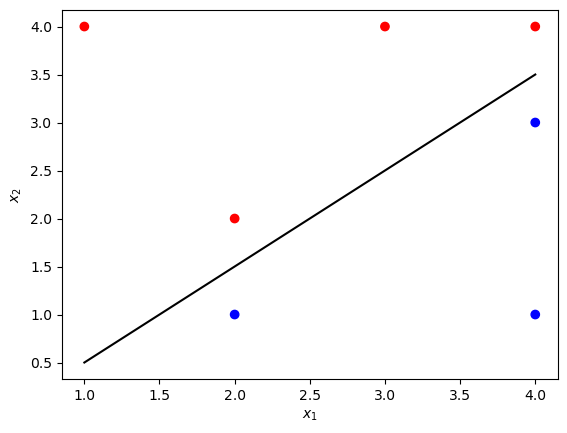

In [37]:
x_line = [1, 2, 3, 4]
y_line = [i-0.5 for i in x_line]

plt.scatter(x1, x2, c=colors)
plt.plot(x_line, y_line, color='black')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()


#### (c) 
Describe the classification rule for the maximal margin classifier. It should be something along the lines of "Classify to Red if $ \beta_0 + \beta_1 X_1 + \beta_2 X_2 > 0 $, and classify to Blue otherwise." Provide the values for $ \beta_0 $, $ \beta_1 $, and $ \beta_2 $.


The classifier above is $ f(x) = 0.5 - x_1 + x_2 $, the model will clssify the point as red if $ f(x) > 0 $


#### (d) 
On your sketch, indicate the margin for the maximal margin hyperplane.


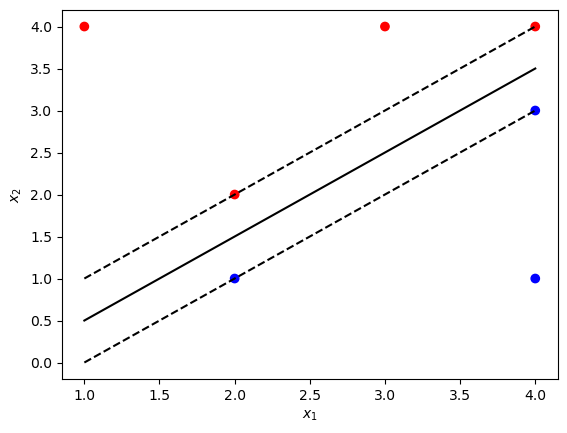

In [38]:
x_margin = [1, 2, 3, 4]
y_margin_1 = [i-1 for i in x_margin]
y_margin_2 = [i for i in x_margin]

plt.scatter(x1, x2, c=colors)
plt.plot(x_line, y_line, color='black')
plt.plot(x_margin, y_margin_1, color='black', linestyle='--')
plt.plot(x_margin, y_margin_2, color='black', linestyle='--')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()


#### (e) 
Indicate the support vectors for the maximal margin classifier.


The support vectors:
- Red: (2, 2), (4, 4)
- Blue: (2, 1), (4, 3)


#### (f) 
Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.


If the movement of the observation is small, the points are still far from the decision boundry because they are not support vectors, and this means the maximal margin hyperplane will not affected.


#### (g) 
Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.


We can change the coefficient of x1, make the equation to $ x_2 = 0.9 * x_1 -0.5 $

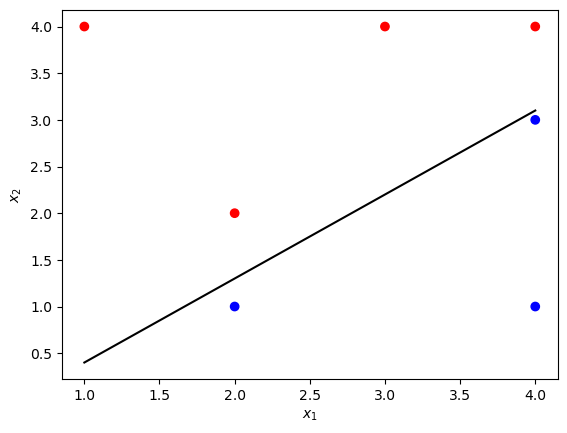

In [39]:
x_line = [1, 2, 3, 4]
y_line = [i*0.9-0.5 for i in x_line]

plt.scatter(x1, x2, c=colors)
plt.plot(x_line, y_line, color='black')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()


#### (h) 
Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

We can add an observation that is very far away from the equation and the color is different from it's adjacent points.

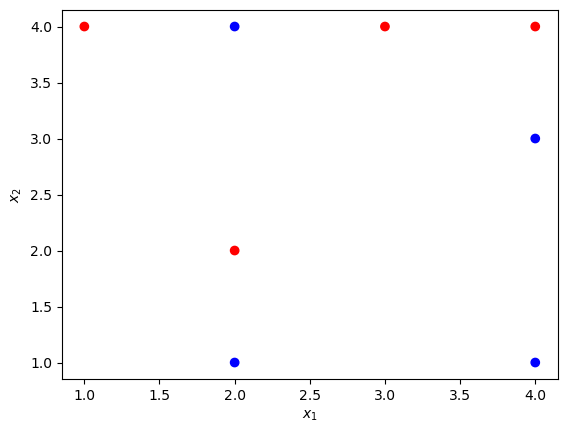

In [40]:
x1 = [3, 2, 4, 1, 2, 4, 4, 2]
x2 = [4, 2, 4, 4, 1, 3, 1, 4]
colors = ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue']

plt.scatter(x1, x2, c=colors)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()